# 1. 에일리언 vs 프레데터 데이터셋
* https://www.kaggle.com/datasets/pmigdal/alien-vs-predator-images
* 케글 로그인 -> 우측 상단의 계정을 클릭 -> Your Profile -> 중앙 메뉴의 Account를 클릭 -> API 항목에 Create New Token을 클릭 -> kaggle.json이 다운로드 됨
* kaggle.json을 메모장으로 열기
  * {"username":"seoholeee","key":"3f2424ea6aa59a6df97dadbf6b666dce"}

In [1]:
import os

In [2]:
os.environ['KAGGLE_USERNAME'] = 'seoholeee'
os.environ['KAGGLE_KEY'] = '3f2424ea6aa59a6df97dadbf6b666dce'

In [3]:
!kaggle datasets download -d pmigdal/alien-vs-predator-images

alien-vs-predator-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
!unzip -q alien-vs-predator-images.zip

replace alien_vs_predator_thumbnails/data/train/alien/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# 2. 이미지 증강 기법(Image Augmentation)
* 원본 이미지(데이터)를 조작하여 원본과는 크고 작은 변화를 가진 이미지를 생성
* 일반적으로 모델 성능이 좋아짐
* 오버피팅을 방지
* https://pytorch.org/vision/master/transforms.html

In [7]:
data_transforms = {
    'train' : transforms.Compose([
        transforms.Resize((224, 224)),
        # 각도, 찌그러뜨림, 크기
        transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
        # 수평으로 뒤집기
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ]),
    'validation': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
}

In [8]:
def target_transforms(target):
  return torch.FloatTensor([target])

In [9]:
image_datasets = {
    'train': datasets.ImageFolder('data/train', data_transforms['train'], target_transform=target_transforms),
    'validation': datasets.ImageFolder('data/validation', data_transforms['validation'], target_transform=target_transforms)
}

In [10]:
dataloaders = {
    'train': DataLoader(
        image_datasets['train'],
        batch_size=32,
        shuffle=True
    ),
    'validation': DataLoader(
        image_datasets['validation'],
        batch_size=32,
        shuffle=False
    )
}

In [11]:
print(len(image_datasets['train']), len(image_datasets['validation']))

694 200


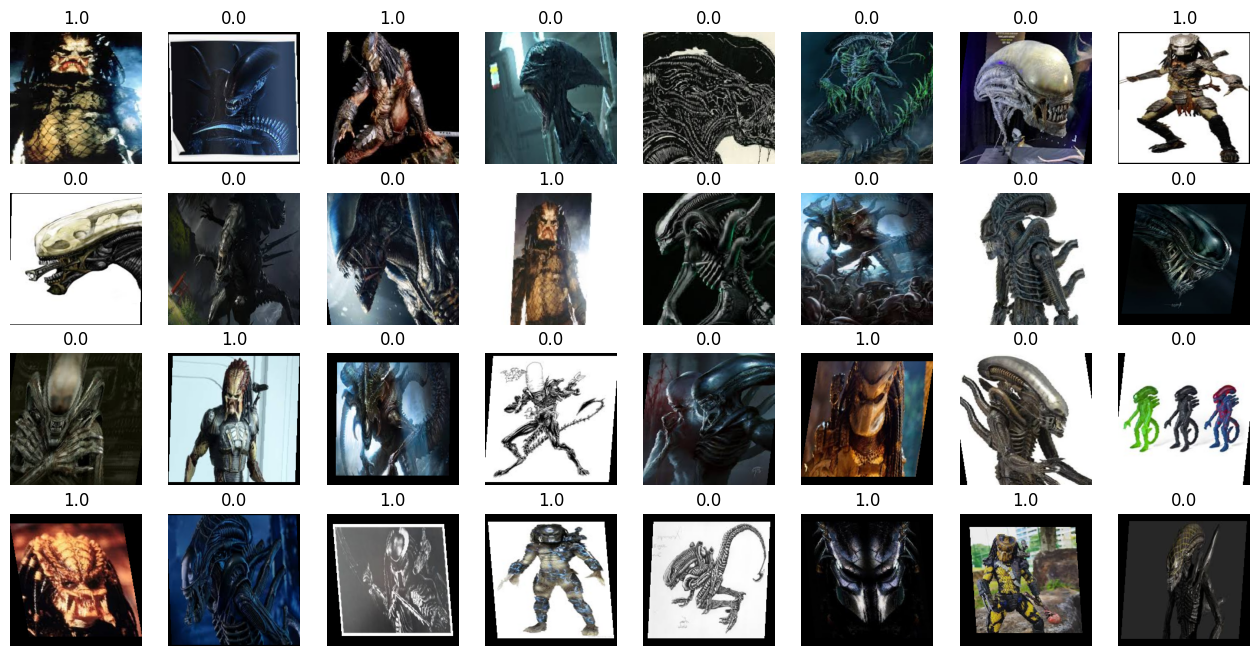

In [12]:
imgs, labels = next(iter(dataloaders['train']))

fig, axes = plt.subplots(4, 8, figsize=(16, 8))

for ax, img, label in zip(axes.flatten(), imgs, labels):
    ax.imshow(img.permute(1, 2, 0)) # (3, 224, 224) -> (224, 224, 3)
    ax.set_title(label.item())
    ax.axis('off')

# 3. 전이 학습(Transfer Learning)
* 하나의 작업을 위해 훈련된 모델을 유사작업 수행 모델의 시작점으로 활용할 수 있는 딥러닝 접근법
* 신경망은 처음부터 새로 학습하는 것보다 전이 학습을 통해 업데이트하고 재학습하는 편이 더 빠르고 간편함
* 전이 학습은 여러 응용 분야(검출, 영상 인식, 음성 인식, 검색 분야, 자연어 분야)에서 많이 사용됨

![](https://miro.medium.com/max/1400/1*9GTEzcO8KxxrfutmtsPs3Q.png)

### 3-1. 전이 학습의 고려할 점
* 크기: 모델 크기는 배포할 위치와 방법에 따라 달라짐
* 속도 및 정확도: 하드웨어, 배치 크기, 모델과 같은 요소를 고려

![](https://kr.mathworks.com/discovery/transfer-learning/_jcr_content/mainParsys/image.adapt.full.medium.jpg/1634621302937.jpg)

### 3-2. 사전 학습된 ResNet50 모델 사용하기
* [파이토치에서 제공하는 사전학습 모델들](https://pytorch.org/vision/stable/models.html)

![](https://i.stack.imgur.com/gI4zT.png)

# 4. 이미지넷(ImageNet)
* 이미지 데이터베이스
* 1000개의 클래스로 동물과 사물 이미지를 포함

![](https://i.imgur.com/5Rz5s8e.png)

In [13]:
model = models.resnet50(weights='IMAGENET1K_V1').to(device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# 5. Freeze Layers
* 특징을 뽑아내는 CNN의 앞쪽 컨볼루션 레이어들은 학습을 하지 않도록 설정
* 출력 부분의 레이어(fc)를 다시 설정하여 분류에 맞게 변경


In [14]:
for param in model.parameters():
  param.requires_gred = False # 가져온 파라미터 (W,b)를 업데이트 하지 않음

In [15]:
model.fc = nn.Sequential(
    nn.Linear(2048, 128),
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Sigmoid()
).to(device)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [17]:
import torch
torch.cuda.empty_cache()

In [18]:
# 학습
# train     : Epoch    1/10 Loss: 0.4399 Accuracy:  81.39%
# validation: Epoch    1/10 Loss: 0.4564 Accuracy:  76.34%

optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

epochs = 10

for epoch in range(epochs):
    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        sum_losses = 0
        sum_accs = 0

        for x_batch, y_batch in dataloaders[phase]:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            y_pred = model(x_batch)
            loss = nn.BCELoss()(y_pred, y_batch)

            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            sum_losses = sum_losses + loss

            y_bool = (y_pred >= 0.5).float()
            acc = (y_batch == y_bool).float().sum() / len(y_batch) * 100
            sum_accs = sum_accs + acc

        avg_loss = sum_losses / len(dataloaders[phase])
        avg_acc = sum_accs / len(dataloaders[phase])
        print(f'{phase:10s}: Epoch {epoch+1:4d}/{epochs} Loss: {avg_loss:.4f} Accuracy: {avg_acc:.2f}%')









train     : Epoch    1/10 Loss: 0.3470 Accuracy: 86.58%


OutOfMemoryError: CUDA out of memory. Tried to allocate 98.00 MiB. GPU 0 has a total capacty of 14.75 GiB of which 79.06 MiB is free. Process 119625 has 14.67 GiB memory in use. Of the allocated memory 14.22 GiB is allocated by PyTorch, and 300.93 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [19]:
from PIL import Image

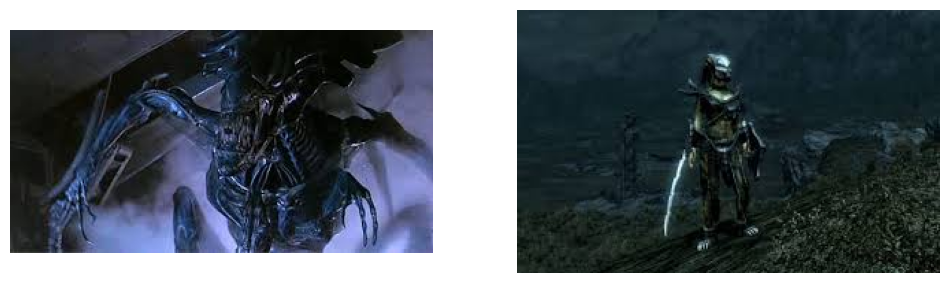

In [21]:
img1 = Image.open('./data/validation/alien/22.jpg')
img2 = Image.open('./data/validation/predator/29.jpg')

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img1)
axes[0].axis('off')
axes[1].imshow(img2)
axes[1].axis('off')
plt.show()

In [22]:
img1_input = data_transforms['validation'](img1)
img2_input = data_transforms['validation'](img2)
print(img1_input.shape)
print(img2_input.shape)

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


In [23]:
test_batch = torch.stack([img1_input, img2_input])
test_batch = test_batch.to(device)
test_batch.shape

torch.Size([2, 3, 224, 224])

In [24]:
y_pred = model(test_batch)
y_pred

tensor([[0.2925],
        [0.5314]], device='cuda:0', grad_fn=<SigmoidBackward0>)

(-0.5, 283.5, 176.5, -0.5)

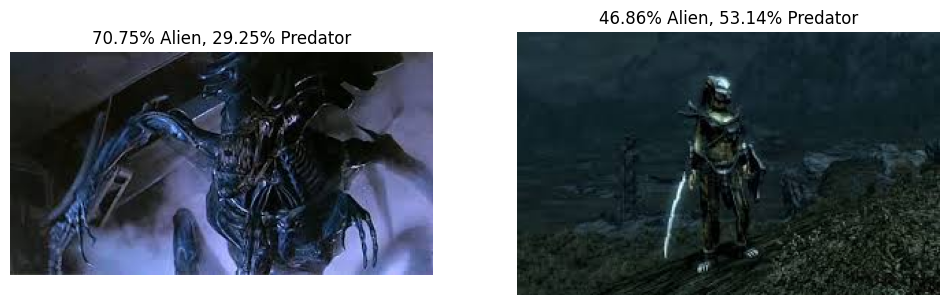

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].set_title(f'{(1-y_pred[0, 0])*100:.2f}% Alien, {(y_pred[0, 0])*100:.2f}% Predator')
axes[0].imshow(img1)
axes[0].axis('off')

axes[1].set_title(f'{(1-y_pred[1, 0])*100:.2f}% Alien, {(y_pred[1, 0])*100:.2f}% Predator')
axes[1].imshow(img2)
axes[1].axis('off')